<a href="https://colab.research.google.com/github/sachaRfd/Drug-Likeness-Prediction/blob/main/Druglikeness_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine learning Predictions for drug likeness score:

Database: 
- Data includes SMILES - logP (water-octanal partition coefficient) - Drug-Likeness
- from https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv

Classic Imports: 

In [1]:
import torch
import torch.nn as nn
import string
import random
import sys
import os
import pandas as pd
import numpy as np


!pip install rdkit -q

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 51.9 MB/s eta 0:00:00
Mounted at /content/drive


Seed-setting function:

In [2]:

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Data was downloaded from: 


In [4]:
data = pd.read_csv('250k_rndm_zinc_drugs.csv')
data

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182
...,...,...,...,...
127302,CS(=O)(=O)Cc1ccccc1NC(=O)CCc1nc(-c2cccs2)no1\n,2.91400,0.658620,2.309214
127303,O=[N+]([O-])c1ccccc1SNCc1ccco1\n,2.98470,0.496595,2.560442
127304,C[NH2+]C[C@@H]1C[C@@]12CCCc1ccc(OC)cc12\n,1.48240,0.847319,4.475605
127305,Cc1ccc(-c2nnc(SCC(=O)Nc3ccc(C#N)c(Cl)c3)o2)cc1\n,4.30090,0.631896,2.152109


Let's check for duplicates: 

In [5]:
data.duplicated().sum()

0

Let's check for missing values: 


In [6]:
data.isna().sum()

smiles    0
logP      0
qed       0
SAS       1
dtype: int64

In [7]:
data.isnull().sum()

smiles    0
logP      0
qed       0
SAS       1
dtype: int64

Now let's add Molecular weights: 

In [8]:
from rdkit.Chem import Descriptors

# Calculated MW - total molecular weight
# Descriptors.MolWt(x)
test = data.smiles.iloc[0]
mol = Chem.MolFromSmiles(test)

Descriptors.MolWt(mol)

325.38300000000004

Number of atoms: 

In [9]:
mol.GetNumAtoms()

24

Now let's add Atomic Composition: 

In [10]:
fp = Chem.RDKFingerprint(mol)

# Convert the fingerprint to a bit string for visualisation: 
bit_string = fp.ToBitString()

# Print the bit string
print(len(bit_string))

2048


Let's try and add the fingerprint to the dataframe by iterating all the strings: 

In [11]:
SMILES = data.smiles.values
fingerprints = [Chem.RDKFingerprint(Chem.MolFromSmiles(i)) for i in SMILES]
data['Finger_print'] = fingerprints
data

,smiles,logP,qed,SAS,Finger_print
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095,"[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, ..."
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ..."
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182,"[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...
127302,CS(=O)(=O)Cc1ccccc1NC(=O)CCc1nc(-c2cccs2)no1\n,2.91400,0.658620,2.309214,"[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
127303,O=[N+]([O-])c1ccccc1SNCc1ccco1\n,2.98470,0.496595,2.560442,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
127304,C[NH2+]C[C@@H]1C[C@@]12CCCc1ccc(OC)cc12\n,1.48240,0.847319,4.475605,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
127305,Cc1ccc(-c2nnc(SCC(=O)Nc3ccc(C#N)c(Cl)c3)o2)cc1\n,4.30090,0.631896,2.152109,"[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


Turn fingerprint into readable BITS



In [12]:
bits = [str(i.ToBitString()) for i in data.Finger_print]
data['BITS'] = bits

In [13]:
data['BITS']

0         0101010010000000111000001100110111101100100001...
1         1010010100010000010000100001000000000000100100...
2         0100100011000101001000010001000000100000001011...
3         1110111111101011111101110111010011100101101101...
4         1000011000001001000110100101010010011101001011...
                                ...                        
127302    1010110000100101100110010000000010010000100000...
127303    0110000000000000000010100010111000100000110000...
127304    0100100000100010100100001001011100101001010010...
127305    0110110010000010001110111001100100001101100010...
127306    1000011111011001001110001000000010001011111101...
Name: BITS, Length: 127307, dtype: object

In [14]:
# Split the BITS column into a list of integers
data['BITS'] = data['BITS'].apply(lambda x: [int(i) for i in x])

In [15]:
# Create a new DataFrame with the new columns
new_columns = pd.DataFrame(data['BITS'].tolist(), columns=['bits_{}'.format(i+1) for i in range(len(data['BITS'][0]))])

# Join the new columns to the original DataFrame
df = pd.concat([data, new_columns], axis=1)

In [18]:
df = df.drop(columns=['BITS'])
df = df.drop(columns='Finger_print')

KeyError: ignored

In [21]:
df

,smiles,logP,qed,SAS,bits_1,bits_2,bits_3,bits_4,bits_5,bits_6,...,bits_2039,bits_2040,bits_2041,bits_2042,bits_2043,bits_2044,bits_2045,bits_2046,bits_2047,bits_2048
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095,0,1,0,1,0,1,...,0,0,1,1,0,0,0,1,0,1
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004,1,0,1,0,0,1,...,1,1,0,1,0,1,1,0,0,1
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753,1,1,1,0,1,1,...,1,1,0,1,0,0,0,1,1,1
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182,1,0,0,0,0,1,...,1,1,0,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127302,CS(=O)(=O)Cc1ccccc1NC(=O)CCc1nc(-c2cccs2)no1\n,2.91400,0.658620,2.309214,1,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
127303,O=[N+]([O-])c1ccccc1SNCc1ccco1\n,2.98470,0.496595,2.560442,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
127304,C[NH2+]C[C@@H]1C[C@@]12CCCc1ccc(OC)cc12\n,1.48240,0.847319,4.475605,0,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,1
127305,Cc1ccc(-c2nnc(SCC(=O)Nc3ccc(C#N)c(Cl)c3)o2)cc1\n,4.30090,0.631896,2.152109,0,1,1,0,1,1,...,1,1,1,0,0,0,0,0,0,1


Let's save the dataframe to csv as it took quite a lot of time to preprocess:

In [22]:
df.to_csv('Pre_processed.csv', index=False)

Great now that we are sure there are no duplicates and missing values, let's start doing some data-analysis and ML.


# Druglikeness Prediction: 

## In this part of the notebook:  Let's predict the druglikeness of chemical compounds. 

First let's fetch the preprocessed dataset from the Pre_processed csv file:

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('drive/MyDrive/saved_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df

,smiles,logP,qed,SAS,bits_1,bits_2,bits_3,bits_4,bits_5,bits_6,...,bits_2039,bits_2040,bits_2041,bits_2042,bits_2043,bits_2044,bits_2045,bits_2046,bits_2047,bits_2048
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095,0,1,0,1,0,1,...,0,0,1,1,0,0,0,1,0,1
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004,1,0,1,0,0,1,...,1,1,0,1,0,1,1,0,0,1
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753,1,1,1,0,1,1,...,1,1,0,1,0,0,0,1,1,1
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182,1,0,0,0,0,1,...,1,1,0,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127302,CS(=O)(=O)Cc1ccccc1NC(=O)CCc1nc(-c2cccs2)no1\n,2.91400,0.658620,2.309214,1,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
127303,O=[N+]([O-])c1ccccc1SNCc1ccco1\n,2.98470,0.496595,2.560442,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
127304,C[NH2+]C[C@@H]1C[C@@]12CCCc1ccc(OC)cc12\n,1.48240,0.847319,4.475605,0,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,1
127305,Cc1ccc(-c2nnc(SCC(=O)Nc3ccc(C#N)c(Cl)c3)o2)cc1\n,4.30090,0.631896,2.152109,0,1,1,0,1,1,...,1,1,1,0,0,0,0,0,0,1


Let's drop the LogP and qed columns for now: AND THE SMILES:

In [3]:
df.drop(columns=['logP', 'qed', 'smiles'], inplace=True)

# Row to Drop
df.iloc[127306]  # as it has NaN
df = df.drop(df.index[127306])


In [4]:
df.isna().sum().sum()

0

In [5]:
df

,SAS,bits_1,bits_2,bits_3,bits_4,bits_5,bits_6,bits_7,bits_8,bits_9,...,bits_2039,bits_2040,bits_2041,bits_2042,bits_2043,bits_2044,bits_2045,bits_2046,bits_2047,bits_2048
0,2.084095,0,1,0,1,0,1,0,0,1,...,0,0,1,1,0,0,0,1,0,1
1,3.432004,1,0,1,0,0,1,0,1,0,...,1,1,0,1,0,1,1,0,0,1
2,2.470633,0,1,0,0,1,0,0,0,1,...,1,0,0,1,0,1,0,0,0,1
3,2.822753,1,1,1,0,1,1,1,1,1,...,1,1,0,1,0,0,0,1,1,1
4,4.035182,1,0,0,0,0,1,1,0,0,...,1,1,0,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127301,3.340292,1,1,1,1,0,1,0,1,0,...,0,1,1,1,0,0,1,1,0,1
127302,2.309214,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
127303,2.560442,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
127304,4.475605,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,1,1


Our x variable will be the SMILES string and Y will be the SAS score: 
  

In [6]:
x = df.drop(columns='SAS')
y = df.SAS

Now let's remove the low variance fingerpring columns:

In [7]:
x.shape

(127306, 2048)

In [8]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.7 * (1-0.7)))
x = selection.fit_transform(x)
x.shape

(127306, 1142)

Let's split the data into train-test set with 60-40 split as data is quite large and i just want to get a model running with a small dataset: 

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, shuffle = True, random_state=42)

Let's now split the train set into train and validation sets: 

In [21]:
x_train, x_val, Y_train, Y_val = train_test_split(x_train, Y_train, test_size=0.2, shuffle = True, random_state = 42)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

LR_model = LinearRegression()

cross_validate(LR_model , x_train, Y_train, cv = 2, n_jobs=-1)

{'fit_time': array([15.40117049, 15.28464532]),
 'score_time': array([0.15177107, 0.18083   ]),
 'test_score': array([0.67970085, 0.68089146])}

In [23]:
LR_model.fit(x_train,Y_train)  # fit the model
y_pred = LR_model.predict(x_val)  # get predicted values for plotting

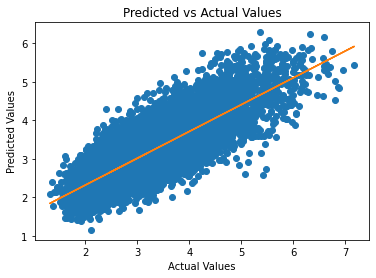

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# plot the predicted values (y_pred) against the actual values (Y_val)
plt.plot(Y_val, y_pred, 'o')

# add a line of best fit to the plot
m, b = np.polyfit(Y_val, y_pred, 1)
plt.plot(Y_val, m*Y_val + b, '-')

# add labels and a title to the plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# show the plot
plt.show()

Let's calculate the R2 score: 

In [25]:
from sklearn.metrics import r2_score

val_score = r2_score(Y_val, y_pred)
val_score

0.6936871321475627

Now for the test set: 

In [26]:
y_prest_test = LR_model.predict(x_test)

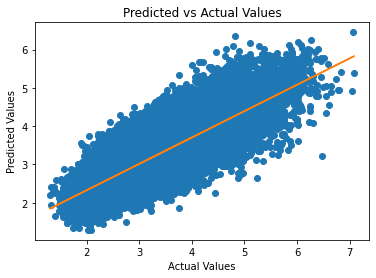

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# plot the predicted values (y_pred) against the actual values (Y_val)
plt.plot(Y_test, y_prest_test, 'o')

# add a line of best fit to the plot
m, b = np.polyfit(Y_test, y_prest_test, 1)
plt.plot(Y_test, m*Y_test + b, '-')

# add labels and a title to the plot
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# show the plot
plt.show()

In [28]:
test_score = r2_score(Y_test, y_prest_test)
test_score

0.684392939390506